# Predictive Models for Acute Oral Systemic Toxicity

The objective of this project is to leverage the combined expertise of the international modeling community to develop predictive models for acute oral toxicity based on regulatory needs submitted by ICCVAM agencies. Models developed for the project will be evaluated, and those meeting defined criteria will be used to generate consensus toxicity predictions of acute oral toxicity endpoints of interest to regulatory agencies. 

Based on the range of regulatory criteria and decision contexts used by ICCVAM agencies, a total of five different modeling endpoints have been identified. Participants can build models to predict one or more of the following endpoints:

+ Very toxic (<50\ mg/kg vs. all others)
+ Nontoxic (>2000\ mg/kg vs. all others)
+ LD50 point estimates
+ Hazard categories under the EPA classification system (n=4) 
+ Hazard categories under the GHS classification system (n=5; Category 5 and Not Classified combined into a single category)


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from rdkit.Chem import PandasTools


## Data exploration of .sdf

In [2]:
sdf_df = PandasTools.LoadSDF('data/trainingset_171127.sdf')

In [3]:
sdf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8987 entries, 0 to 8993
Data columns (total 15 columns):
CASRN               8987 non-null object
Canonical_QSARr     8987 non-null object
DTXSID              8987 non-null object
EPA_category        8987 non-null object
GHS_category        8987 non-null object
ID                  8987 non-null object
InChI Key_QSARr     8987 non-null object
InChI_Code_QSARr    8987 non-null object
LD50_mgkg           8987 non-null object
Name                8987 non-null object
ROMol               8987 non-null object
Salt_Solvent        8987 non-null object
Structure_Source    8987 non-null object
nontoxic            8987 non-null object
very_toxic          8987 non-null object
dtypes: object(15)
memory usage: 1.1+ MB


### Data cleaning and assertion of labels

In [4]:
# objects to numeric
sdf_df.LD50_mgkg = pd.to_numeric(sdf_df.LD50_mgkg)
sdf_df.GHS_category = pd.to_numeric(sdf_df.GHS_category)
sdf_df.EPA_category = pd.to_numeric(sdf_df.EPA_category)

# TRUE/FALSE to bolean
bool_dict = {'FALSE':False, 'TRUE':True}
sdf_df.nontoxic = sdf_df.nontoxic.map(bool_dict)
sdf_df.very_toxic = sdf_df.very_toxic.map(bool_dict)

,CASRN,Canonical_QSARr,DTXSID,EPA_category,GHS_category,ID,InChI Key_QSARr,InChI_Code_QSARr,LD50_mgkg,Name,ROMol,Salt_Solvent,Structure_Source,nontoxic,very_toxic
0,5894-60-0,CCCCCCCCCCCCCCCC[Si](Cl)(Cl)Cl,DTXSID10884196,NaN,NaN,5894-60-0,RYPYGDUZKOPBEL-UHFFFAOYSA-N,"InChI=1S/C16H33Cl3Si/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-20(17,18)19/h2-16H2,1H3",NaN,"Silane, trichlorohexadecyl-",,?,EPA_DSSTox,False,False
1,101-20-2,O=C(NC1C=C(Cl)C(Cl)=CC=1)NC1C=CC(Cl)=CC=1,DTXSID4026214,NaN,5.0,101-20-2,ICUTUKXCWQYESQ-UHFFFAOYSA-N,"InChI=1S/C13H9Cl3N2O/c14-8-1-3-9(4-2-8)17-13(19)18-10-5-6-11(15)12(16)7-10/h1-7H,(H2,17,18,19)",NaN,Triclocarban,,?,EPA_DSSTox,True,False

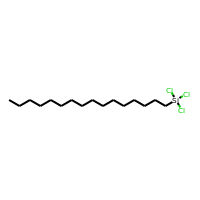
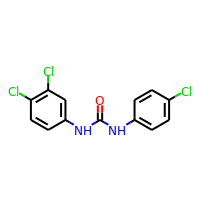

In [5]:
sdf_df.head(2)

The molecules with  50 < LD50 < 2000 have `False` in both `very_toxic` and `nontoxic` columns:

In [6]:
sdf_df[(sdf_df.LD50_mgkg < 2000) & (sdf_df.LD50_mgkg > 50)][['very_toxic', 'nontoxic']].sum(axis=0)

very_toxic    0.0
nontoxic      0.0
dtype: float64

Text(0.5,1,'very toxic')

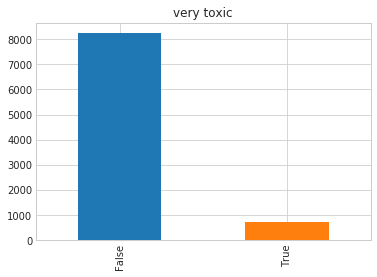

In [7]:
sdf_df.very_toxic.value_counts().plot.bar()
plt.title('very toxic')

Text(0.5,1,'nontoxic')

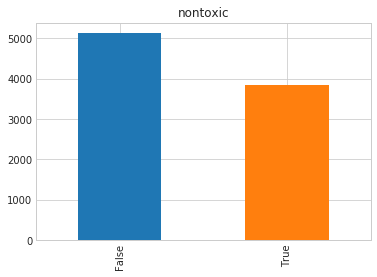

In [8]:
sdf_df.nontoxic.value_counts().plot.bar()
plt.title('nontoxic')

Text(0.5,1,'Nans')

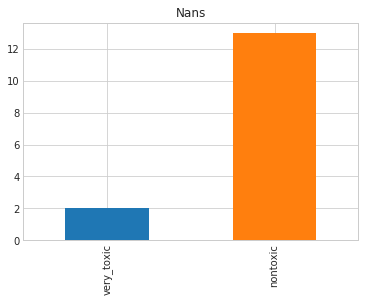

In [9]:
sdf_df[['very_toxic', 'nontoxic']].isna().sum().plot.bar()
plt.title('Nans')

There is no values with `True` in both `very_toxic` and `nontoxic` columns:

In [10]:
len(sdf_df[sdf_df.nontoxic & sdf_df.very_toxic])

0

In [11]:
len(sdf_df[sdf_df.very_toxic.isna()])

2

In [12]:
sdf_df.nontoxic.unique()

array([False, True, nan], dtype=object)

In [13]:
sdf_df.very_toxic.unique()

array([False, True, nan], dtype=object)

### Filter null to create the new label:

In [14]:
sdf_df = sdf_df[pd.notnull(sdf_df.very_toxic)]
sdf_df = sdf_df[pd.notnull(sdf_df.nontoxic)]
sdf_df.reset_index(inplace=True)

Now we are going to transform the two labels `very_toxic`and `nontoxic` into a single one like this:

| very_toxic| nontoxic   | Label |
|-----------|------------|-------|
| False     | True       | **0** |
| False     | False      | **1** |
| True      | False      | **2** |


In [15]:
def labelizer(v1, v2):
    label = []
    for i in range(len(v1)):
        if (v1[i] == False) & (v2[i] == True):
            label.append(0)
        elif (v1[i] == False) & (v2[i] == False):
            label.append(1)
        elif (v1[i] == True) & (v2[i] == False):
            label.append(2)
    return label

In [16]:
sdf_df['labels'] = labelizer(sdf_df.very_toxic, sdf_df.nontoxic)

### Balance:

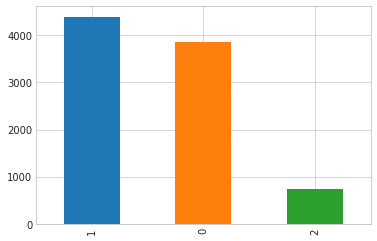

In [17]:
sdf_df['labels'].value_counts().plot.bar()

In [18]:
percent0 = (sum(sdf_df['labels'] == 0)/len(sdf_df)) * 100
percent1 = (sum(sdf_df['labels'] == 1)/len(sdf_df)) * 100
percent2 = (sum(sdf_df['labels'] == 2)/len(sdf_df)) * 100

print(f'A {round(percent0, 2)}% of the dataset is nontoxic (LD50 > 2000 mg/kg)')
print(f'A {round(percent1, 2)}% of the dataset is between toxic and nontoxic (50 mg/kg < LD50 < 2000 mg/kg)')
print(f'A {round(percent2, 2)}% of the dataset is very toxic (LD50 < 50 mg/kg)')


A 42.84% of the dataset is nontoxic (LD50 > 2000 mg/kg)
A 48.9% of the dataset is between toxic and nontoxic (50 mg/kg < LD50 < 2000 mg/kg)
A 8.26% of the dataset is very toxic (LD50 < 50 mg/kg)


## Calculate fingerprints

In [19]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [20]:
# get the fingerprints

fps = []
for m in sdf_df.ROMol:
    fp =  AllChem.GetMorganFingerprintAsBitVect(mol=m, radius=3, nBits=1024)
    fps.append(fp)

np_fps = []
for fp in fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

assert len(np_fps) == len(sdf_df['labels'])

## PCA and ploting

In [21]:
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = (15,10)

In [22]:
pca = PCA(n_components=5)
components = pca.fit_transform(np_fps)

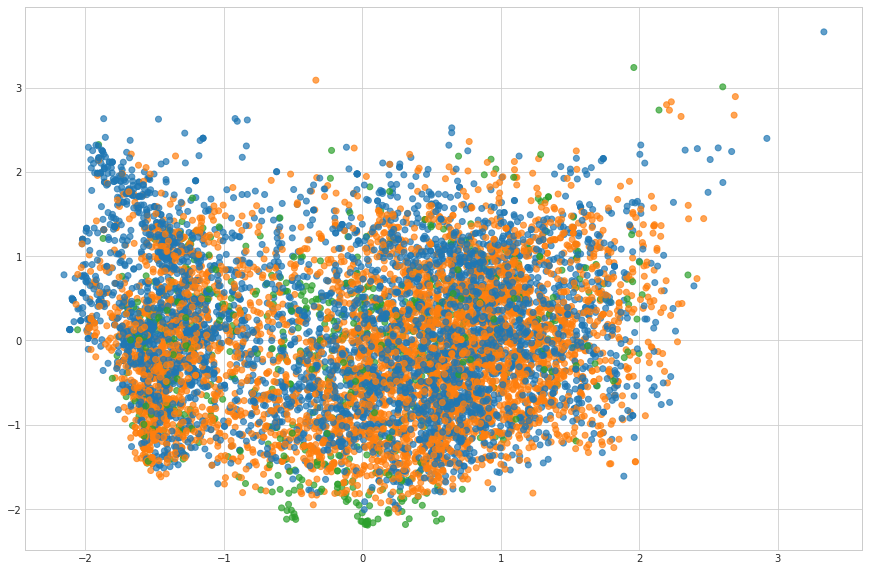

In [23]:
cols = {0:'C0', 1:'C1', 2:'C2'}  # blue, orange, green
colors = sdf_df['labels'].map(cols)

plt.scatter(components[:,0], components[:,1], c=colors, alpha =0.7)

### TSNE

In [33]:
from sklearn.manifold import TSNE

In [34]:
_kwargs = dict(n_components=2,
              perplexity=10.0,
              early_exaggeration=12.0,
              learning_rate=200.0,
              n_iter=1000,
              n_iter_without_progress=300,
              min_grad_norm=1e-07,
              metric='euclidean',
              init='pca',
              verbose=1,
              random_state=None,
              method='barnes_hut',
              angle=0.5)


In [35]:
tsne = TSNE(**_kwargs)

In [36]:
lowD_map = tsne.fit_transform(np_fps)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 8972 samples in 1.194s...
[t-SNE] Computed neighbors for 8972 samples in 125.445s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8972
[t-SNE] Computed conditional probabilities for sample 2000 / 8972
[t-SNE] Computed conditional probabilities for sample 3000 / 8972
[t-SNE] Computed conditional probabilities for sample 4000 / 8972
[t-SNE] Computed conditional probabilities for sample 5000 / 8972
[t-SNE] Computed conditional probabilities for sample 6000 / 8972
[t-SNE] Computed conditional probabilities for sample 7000 / 8972
[t-SNE] Computed conditional probabilities for sample 8000 / 8972
[t-SNE] Computed conditional probabilities for sample 8972 / 8972
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.512260
[t-SNE] Error after 1000 iterations: 2.165308


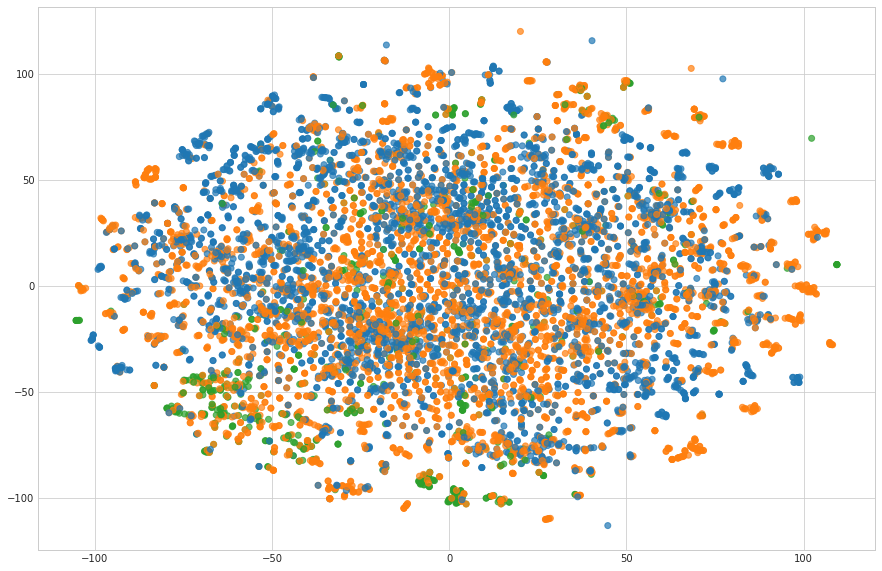

In [39]:
plt.scatter(lowD_map[:,0], lowD_map[:,1], c=colors, alpha =0.7)

In [25]:
from sklearn.neighbors import kneighbors_graph

In [40]:
_kwargs2 = dict(n_components=2,
              perplexity=5.0,
              early_exaggeration=12.0,
              learning_rate=200.0,
              n_iter=10000,
              n_iter_without_progress=300,
              min_grad_norm=1e-07,
              metric='jaccard',
              init='pca',
              verbose=1,
              random_state=None,
              method='barnes_hut',
              angle=0.5)

In [41]:
tsne2 = TSNE(**_kwargs2)

In [ ]:
lowD_map2 = tsne2.fit_transform(np_fps)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 8972 samples in 1.342s...
[t-SNE] Computed neighbors for 8972 samples in 184.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8972
[t-SNE] Computed conditional probabilities for sample 2000 / 8972
[t-SNE] Computed conditional probabilities for sample 3000 / 8972
[t-SNE] Computed conditional probabilities for sample 4000 / 8972
[t-SNE] Computed conditional probabilities for sample 5000 / 8972
[t-SNE] Computed conditional probabilities for sample 6000 / 8972
[t-SNE] Computed conditional probabilities for sample 7000 / 8972
[t-SNE] Computed conditional probabilities for sample 8000 / 8972
[t-SNE] Computed conditional probabilities for sample 8972 / 8972
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.169464


In [ ]:
plt.scatter(lowD_map2[:,0], lowD_map2[:,1], c=colors, alpha =0.7)